### **필요 라이브러리 호출**

In [1]:
import pandas as pd
import yfinance as yf
from polygon import RESTClient
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
import os
from langchain_core.tools import tool
from pathlib import Path
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()
os.getcwd()

'/Users/hyeonjinho/Desktop/dev/Learned/llm/fastcampus-kane-langgraph-multi-aiagent/4/4'

### **Polygon API 사이트**

#### Polygon 홈페이지 !https://polygon.io/
#### Polygon 주가 정보 !https://polygon.io/dashboard

In [ ]:
BASE_DIR = Path(os.getcwd())  # 현재 작업 디렉토리
DATA_DIR = BASE_DIR / "data"  # 데이터 저장용 디렉토리
CHART_DIR = BASE_DIR / "charts"  # 차트 저장용 디렉토리

polygon_client = RESTClient(api_key=os.environ["POLYGON_API_KEY"])

### **yfinance, Polygon API로 자사, 경쟁사 주식정보 가져오기**

In [3]:
related_companies = polygon_client.get_related_companies("NVDA")
competitors = [i.ticker for i in related_companies]
competitors

['AMD',
 'META',
 'GOOGL',
 'TSLA',
 'GOOG',
 'MSFT',
 'AMZN',
 'AAPL',
 'INTC',
 'AVGO']

In [15]:
@tool
def fetch_stock_data(ticker: str, start_date: str, end_date: str):
    """Fetch stock data and compare with NASDAQ and competitors."""
    stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
    nasdaq = yf.download('^IXIC', start=start_date, end=end_date, progress=False)
    df = pd.DataFrame(index=stock.index)
    df[f'{ticker}'] = stock['Close']
    df['Nasdaq'] = nasdaq['Close']
    
    related_companies = polygon_client.get_related_companies(ticker)
    competitors = [i.ticker for i in related_companies]
    
    for comp in competitors:
        try:
            comp_ticker = comp.replace('.', '-') if '.' in comp else comp
            comp_data = yf.download(comp_ticker, start=start_date, end=end_date, progress=False)
            if not comp_data.empty:
                df[comp] = comp_data['Close']
        except Exception as e:
            continue

    csv_path = DATA_DIR / "stock_data.csv"
    df.to_csv(csv_path)
    return f"Stock file saved to {csv_path}"

In [16]:
fetch_stock_data.run({"ticker":"NVDA", 
                      "start_date":"2023-01-01", 
                      "end_date":"2024-01-01"})

MultiIndex([( 'Close', 'NVDA'),
            (  'High', 'NVDA'),
            (   'Low', 'NVDA'),
            (  'Open', 'NVDA'),
            ('Volume', 'NVDA')],
           names=['Price', 'Ticker'])


'Stock file saved to /Users/hyeonjinho/Desktop/dev/Learned/llm/fastcampus-kane-langgraph-multi-aiagent/4/4/data/stock_data.csv'

### **Polygon API로 재무 정보 가져오기**

In [ ]:
client = polygon_client

# 최근 n개년간 분기별 재무제표 데이터 수집
import time

financials = []
for f in client.vx.list_stock_financials("NVDA", filing_date_gte="2023-01-01", filing_date_lt="2024-01-01"):
    if "Q" in f.fiscal_period and f.end_date >= f"{pd.Timestamp.now().year - 3}-01-01":
        financials.append(f)

StockFinancial(cik='0001045810', company_name='NVIDIA CORP', end_date='2023-10-29', filing_date='2023-11-21', financials=Financials(balance_sheet=BalanceSheet(assets=DataPoint(label='Assets', order=100, unit='USD', value=54148000000.0, derived_from=None, formula=None, source=None, xpath=None), current_assets=DataPoint(label='Current Assets', order=200, unit='USD', value=32658000000.0, derived_from=None, formula=None, source=None, xpath=None), cash=DataPoint(label=None, order=None, unit=None, value=None, derived_from=None, formula=None, source=None, xpath=None), accounts_receivable=DataPoint(label=None, order=None, unit=None, value=None, derived_from=None, formula=None, source=None, xpath=None), inventory=DataPoint(label='Inventory', order=230, unit='USD', value=4779000000.0, derived_from=None, formula=None, source=None, xpath=None), prepaid_expenses=DataPoint(label=None, order=None, unit=None, value=None, derived_from=None, formula=None, source=None, xpath=None), other_current_assets=D

[StockFinancial(cik='0001045810', company_name='NVIDIA CORP', end_date='2023-10-29', filing_date='2023-11-21', financials=Financials(balance_sheet=BalanceSheet(assets=DataPoint(label='Assets', order=100, unit='USD', value=54148000000.0, derived_from=None, formula=None, source=None, xpath=None), current_assets=DataPoint(label='Current Assets', order=200, unit='USD', value=32658000000.0, derived_from=None, formula=None, source=None, xpath=None), cash=DataPoint(label=None, order=None, unit=None, value=None, derived_from=None, formula=None, source=None, xpath=None), accounts_receivable=DataPoint(label=None, order=None, unit=None, value=None, derived_from=None, formula=None, source=None, xpath=None), inventory=DataPoint(label='Inventory', order=230, unit='USD', value=4779000000.0, derived_from=None, formula=None, source=None, xpath=None), prepaid_expenses=DataPoint(label=None, order=None, unit=None, value=None, derived_from=None, formula=None, source=None, xpath=None), other_current_assets=

In [39]:
@tool
def get_financial_data(ticker: str, num_years: int):
    """
    주어진 티커의 재무 데이터를 가져와 DataFrame으로 저장하고 파일 경로를 반환합니다.
    
    Parameters:
    ticker (str): 종목 코드
    num_years (int): 가져올 연도 수
    
    Returns:
    str: 저장된 파일 경로 메시지
    """
    # Polygon REST API Client 설정
    client = polygon_client
    
    # 최근 n개년간 분기별 재무제표 데이터 수집
    financials = []
    for f in client.vx.list_stock_financials(ticker, filing_date_gte="2023-01-01", filing_date_lt="2024-01-01"):
        if "Q" in f.fiscal_period and f.end_date >= f"{pd.Timestamp.now().year - num_years}-01-01":
            time.sleep(1)
            financials.append(f)
    
    # DataFrame 생성할 데이터 목록 초기화
    data = {
        # 기본 정보
        "Fiscal Year": [],
        "Fiscal Period": [],
        "End Date": [],
        
        # 손익계산서 항목
        "Revenues": [],
        "Cost of Revenue": [],
        "Gross Profit": [],
        "Operating Income": [],
        "Operating Expenses": [],
        "Basic EPS": []
    }
    
    # 각 재무제표 항목에서 지표들을 추출하여 DataFrame 구성
    for i, f in enumerate(financials):
        # 기본 정보
        data["Fiscal Year"].append(f.fiscal_year)
        data["Fiscal Period"].append(f.fiscal_period)
        data["End Date"].append(f.end_date)

        # 재무제표 데이터 접근
        bs = f.financials.balance_sheet
        is_ = f.financials.income_statement
        cf = f.financials.cash_flow_statement
        ci = f.financials.comprehensive_income

        # 손익계산서 데이터 추출
        revenue = getattr(is_.revenues, 'value', None) if hasattr(is_, 'revenues') else None
        data["Revenues"].append(revenue)
        data["Cost of Revenue"].append(getattr(is_.cost_of_revenue, 'value', None) if hasattr(is_, 'cost_of_revenue') else None)
        data["Gross Profit"].append(getattr(is_.gross_profit, 'value', None) if hasattr(is_, 'gross_profit') else None)
        data["Operating Expenses"].append(getattr(is_.operating_expenses, 'value', None) if hasattr(is_, 'operating_expenses') else None)
        data["Operating Income"].append(getattr(is_.operating_expenses, 'value', None) if hasattr(is_, 'operating_expenses') else None)
        data["Basic EPS"].append(getattr(is_.basic_earnings_per_share, 'value', None) if hasattr(is_, 'basic_earnings_per_share') else None)
        
    # DataFrame 생성 및 정렬
    df = pd.DataFrame(data)
    df.sort_values(by="End Date", ascending=False, inplace=True)
    
    # 한글 컬럼명으로 변경
    korean_columns = {
        "Fiscal Year": "회계연도",
        "Fiscal Period": "회계기간",
        "End Date": "기준일",
        "Revenues": "매출액",
        "Cost of Revenue": "매출원가",
        "Gross Profit": "매출총이익",
        "Operating Income": "영업이익",
        "Operating Expenses": "영업비용",
        "Basic EPS": "기본주당순이익"
    }
    
    df.rename(columns=korean_columns, inplace=True)
    
    # CSV 파일로 저장
    csv_path = DATA_DIR / "finance_data.csv"
    df.to_csv(csv_path, encoding='utf-8-sig')  # utf-8-sig로 저장하여 한글 깨짐 방지
    return f"재무제표 데이터가 {csv_path}에 저장되었습니다."

In [40]:
get_financial_data.run({"ticker": "NVDA", "num_years": 3})

'재무제표 데이터가 /Users/hyeonjinho/Desktop/dev/Learned/llm/fastcampus-kane-langgraph-multi-aiagent/4/4/data/finance_data.csv에 저장되었습니다.'

#### **create_pandas_dataframe_agent로 데이터 분석 도구 만들기**

In [41]:
@tool
def analyze_data(query: str):
    """저장된 주식 데이터와 재무 데이터를 pandas_agent로 분석하고 질문에 답변합니다."""
    stock_csv_path = DATA_DIR / "stock_data.csv"
    finance_csv_path = DATA_DIR / "finance_data.csv"
    stock_df = pd.read_csv(stock_csv_path)
    finance_df = pd.read_csv(finance_csv_path)
    custom_prefix = f"""
    You are very smart analyst who can use stock_data and finance_data.
    Please analyze the data in various perspective to find valuable insight.
    You should always make the greatest output with accurate metrics and tables.
    stock_data path: {stock_csv_path}
    finance_data path: {finance_csv_path}
    """
    pandas_agent = create_pandas_dataframe_agent(
        ChatOpenAI(model="gpt-4o"),
        [stock_df, finance_df],
        verbose=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix=custom_prefix
    )
    
    result = pandas_agent.run(query)
    return result

/var/folders/1x/st3vh8xs6715dcgqc1gk2hhh0000gn/T/ipykernel_61330/435105087.py:24: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = pandas_agent.run(query)




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the stock data\ndf_stocks = pd.read_csv('/Users/hyeonjinho/Desktop/dev/Learned/llm/fastcampus-kane-langgraph-multi-aiagent/4/4/data/stock_data.csv')\n\ndf_stocks['Date'] = pd.to_datetime(df_stocks['Date'])\n\n# Plot the NVDA price trend\ndf_stocks.plot(x='Date', y='NVDA', title='NVDA Stock Price Trend', figsize=(10, 6))\nplt.xlabel('Date')\nplt.ylabel('Price')\nplt.grid(True)\nplt.show()"}`




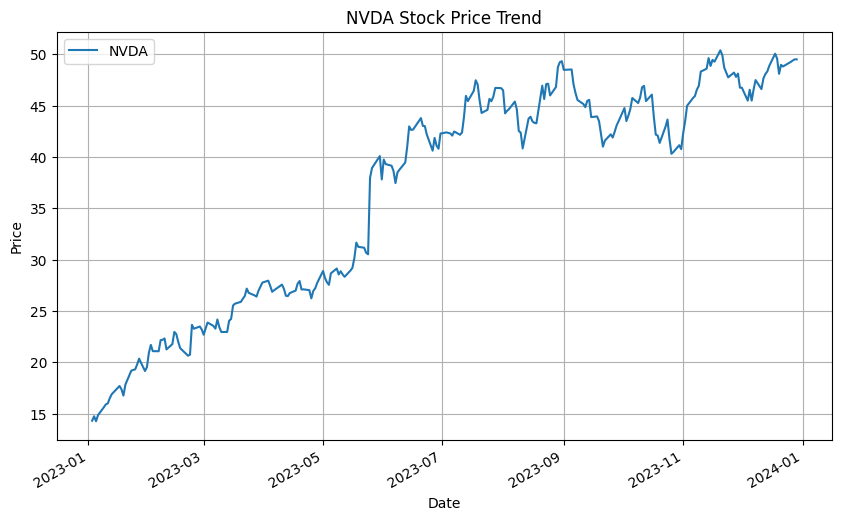

Here is the plot depicting the price trend of NVDA over the specified period. The graph visualizes the fluctuations and overall trend in NVDA's stock price based on the provided dataset.

If you'd like any additional insights or analysis regarding the trend, feel free to ask!

> Finished chain.


"Here is the plot depicting the price trend of NVDA over the specified period. The graph visualizes the fluctuations and overall trend in NVDA's stock price based on the provided dataset.\n\nIf you'd like any additional insights or analysis regarding the trend, feel free to ask!"

In [42]:
analyze_data.run({"query":"NVDA 가격 추이를 분석해줘"})

### **차트 생성 도구 만들기**

In [43]:
@tool
def chart_generator(command: str):
    """이 도구는 create_pandas_dataframe_agent를 사용하여 차트를 생성하고 차트를 /charts 폴더에 저장합니다."""
    stock_data = pd.read_csv(DATA_DIR / "stock_data.csv")
    finance_data = pd.read_csv(DATA_DIR / "finance_data.csv")
    custom_prefix = """
    Please make the chart and save in './charts' folder.
    stock_data path is './data/stock_data.csv'.
    finance_data path is './data/finance_data.csv'
    """
    agent = create_pandas_dataframe_agent(
        ChatOpenAI(model_name="gpt-4o"), 
        [stock_data, finance_data], 
        verbose=True,
        allow_dangerous_code=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        prefix=custom_prefix
    )
    result = agent.invoke(command)
    return result



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the stock data\ndf_stock = pd.read_csv('./data/stock_data.csv')\n\n# Parse the dates\ndf_stock['Date'] = pd.to_datetime(df_stock['Date'])\n\n# Plotting NVDA stock prices\nplt.figure(figsize=(10, 6))\nplt.plot(df_stock['Date'], df_stock['NVDA'], label='NVDA')\nplt.title('NVDA Stock Prices Over Time')\nplt.xlabel('Date')\nplt.ylabel('Stock Price')\nplt.grid(True)\nplt.legend()\nplt.savefig('./charts/nvda_stock_price.png')\nplt.show()"}`


FileNotFoundError: [Errno 2] No such file or directory: './charts/nvda_stock_price.png'

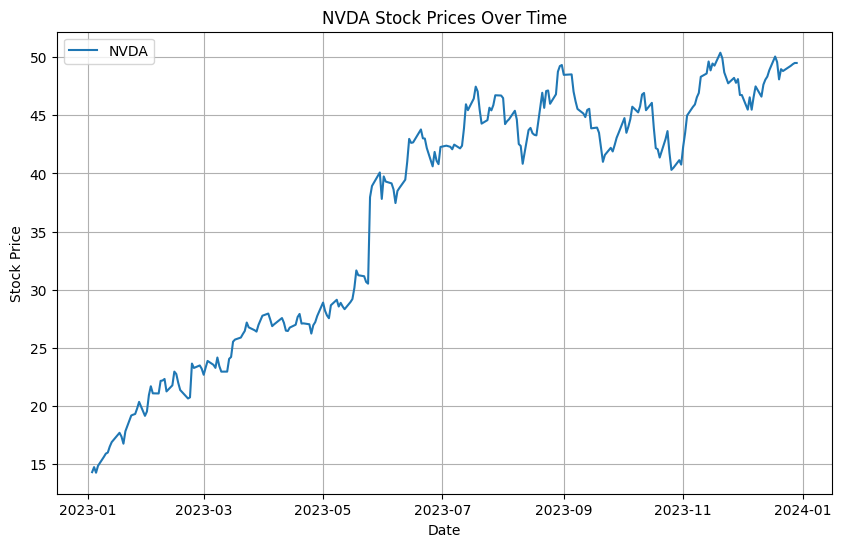

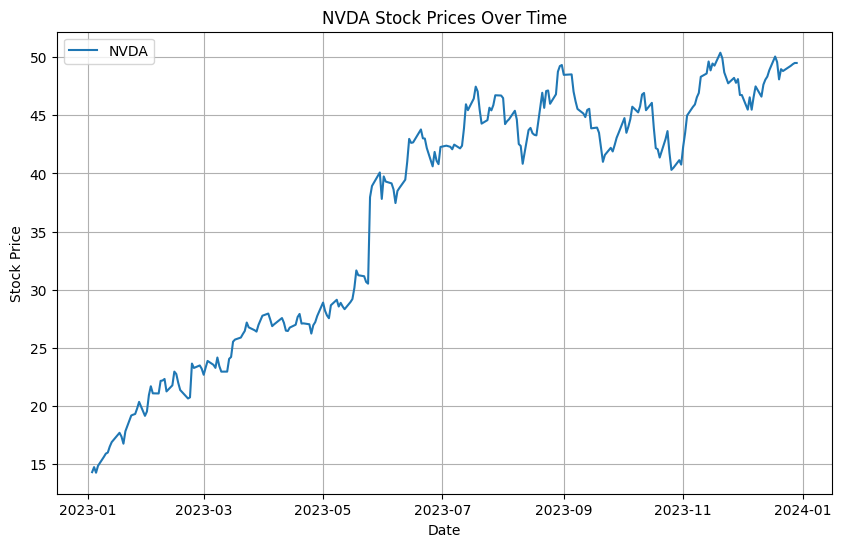


Invoking: `python_repl_ast` with `{'query': "import os\nos.makedirs('./charts', exist_ok=True)\n\n# Save the chart again\nplt.figure(figsize=(10, 6))\nplt.plot(df_stock['Date'], df_stock['NVDA'], label='NVDA')\nplt.title('NVDA Stock Prices Over Time')\nplt.xlabel('Date')\nplt.ylabel('Stock Price')\nplt.grid(True)\nplt.legend()\nplt.savefig('./charts/nvda_stock_price.png')\nplt.show()"}`


The NVDA stock price chart has been successfully created and saved in the `./charts` folder as `nvda_stock_price.png`.

> Finished chain.


{'input': 'NVDA stock price chart',
 'output': 'The NVDA stock price chart has been successfully created and saved in the `./charts` folder as `nvda_stock_price.png`.'}

In [44]:
chart_generator.run({"command":"NVDA stock price chart"})